In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import jax
from jax import jit
from jax.lib import xla_bridge
print(f"Jax is using: {xla_bridge.get_backend().platform}")

Jax is using: gpu


# Simulate data

In [3]:
# define linear ultrasound transducer (P4-1)
nelements = 64
element_pitch = 2.95e-4 # distance between transducer elements
transducer_extent = (nelements - 1) * element_pitch # length of the transducer [m]
transducer_frequency = 1e6 # frequency of the transducer [Hz]
transducer_magnitude = 1e6 # magnitude of the transducer [Pa]
print(f"Transducer extent: {transducer_extent:.3f} m")

Transducer extent: 0.019 m


2024-08-11 20:08:20.807079: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


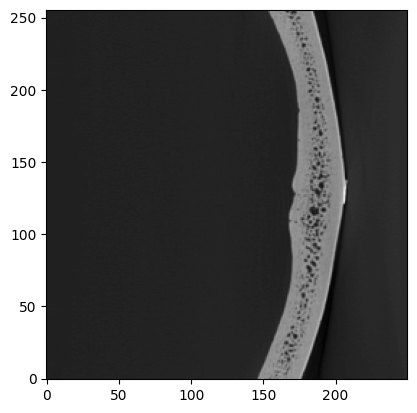

In [4]:
import pydicom

# define skull slice
skull_dicom = pydicom.dcmread("../data/skull_slice.dcm")
skull_array = skull_dicom.pixel_array.astype(np.int16)
skull_array = skull_array[:500, 600:-600]
skull_array = np.flipud(skull_array)
downsampling_factor = 2
new_shape = (skull_array.shape[0] // downsampling_factor, skull_array.shape[1] // downsampling_factor)
skull_array = jax.image.resize(skull_array, new_shape, method='nearest').T
plt.imshow(skull_array, cmap='gray')
plt.gca().invert_yaxis()
plt.show()

In [5]:
# define spatial parameters
N = np.array(skull_array.shape).astype(int) # grid size [grid points]
dx = np.array([9.07935931401377e-5*downsampling_factor, 9.07935931401377e-5*downsampling_factor]) # grid spacing [m]
pml = np.array([20, 20]) # size of the perfectly matched layer [grid points]

In [6]:
# define transducer position in domain
transducer_depth = pml[1] # depth of the transducer [grid points]
transducer_x_start = N[0]//2 - nelements//2 # start index of the transducer in the x-direction [grid points]
element_positions = np.array([
    np.linspace(transducer_x_start, transducer_x_start + nelements - 1, nelements),
    (N[1] - transducer_depth) * np.ones(nelements),
], dtype=int)
element_positions

array([[ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
        122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
        135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159],
       [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230]])

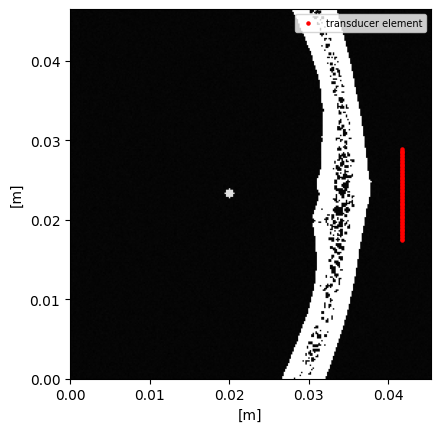

In [7]:
from jwave_utils import get_domain, get_homogeneous_medium, get_skull_medium

# define jwave medium
domain = get_domain(N, dx)
speed_homogeneous, density_homogeneous = get_homogeneous_medium(domain, background_std=0, background_seed=29)

scatterer_positions = np.array([[domain.N[0]//2, domain.N[1]//2-15]], dtype=int)
speed_skull, density_skull = get_skull_medium(domain, skull_array, background_std=0, background_seed=29)
speed, density = get_skull_medium(domain, skull_array, scatterer_positions, 
                          background_std = 0.004, scatterer_radius=3, scatterer_contrast=1.7, 
                          background_seed=28)

ext = [0, N[1]*dx[1], N[0]*dx[0], 0]
plt.scatter(element_positions[1]*dx[1], element_positions[0]*dx[0],
            c='r', marker='o', s=5, label='transducer element')
plt.imshow(speed, cmap='gray', extent=ext)
# plt.colorbar(label='Speed of sound [m/s]')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.legend(prop={'size': 7})
plt.gca().invert_yaxis()
plt.show()

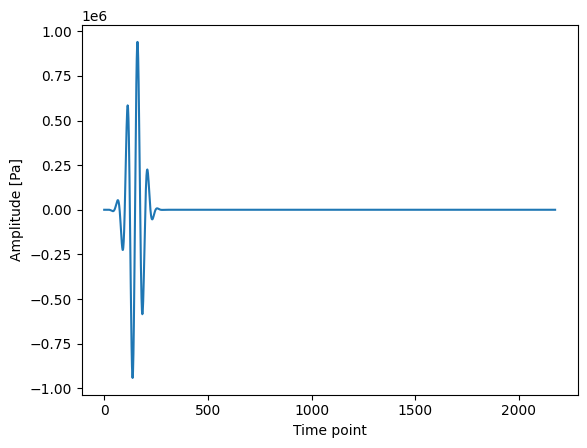

In [8]:
from jwave.geometry import TimeAxis
from jwave.geometry import Medium
from jwave import FourierSeries
from jwave_utils import get_plane_wave_excitation

signal_delay = 0
medium = Medium(domain, FourierSeries(jnp.expand_dims(speed, -1), domain), FourierSeries(jnp.expand_dims(density, -1), domain), pml_size=pml[0])
time_axis = TimeAxis.from_medium(medium, cfl=0.3)
# sources = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, element_positions)
sources, signal, carrier_signal = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, element_positions, signal_delay=signal_delay)


plt.plot(sources.signals[0])
plt.xlabel('Time point')
plt.ylabel('Amplitude [Pa]')
plt.show()

In [9]:
from jwave_utils import get_data

# simulate data using jwave
pressure, data = get_data(speed, density, domain, time_axis, sources, element_positions)
_, data_homogenous = get_data(speed_homogeneous, density_homogeneous, domain, time_axis, sources, element_positions)
_, data_skull = get_data(speed_skull, density_skull, domain, time_axis, sources, element_positions)

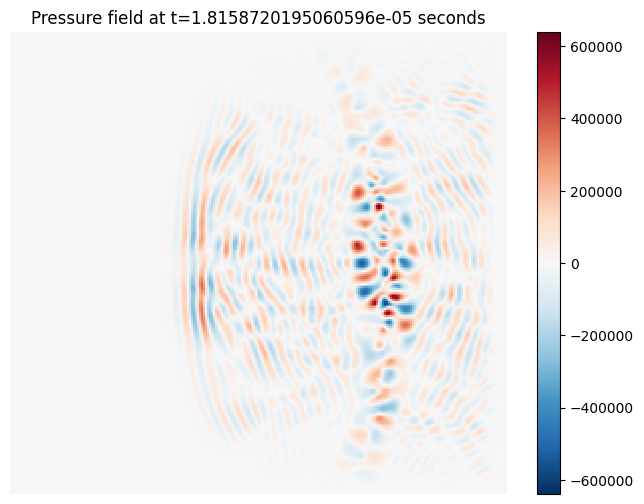

In [10]:
from jwave.utils import show_field

t_idx = 900
show_field(pressure[t_idx])
plt.title(f"Pressure field at t={time_axis.to_array()[t_idx]} seconds")
plt.show()

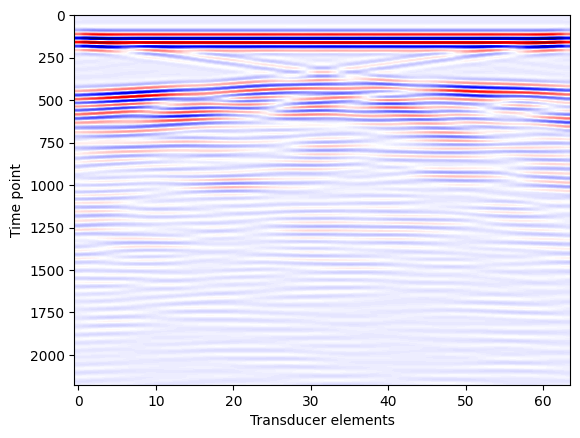

In [11]:
plt.imshow(data, aspect='auto', cmap='seismic')
plt.xlabel('Transducer elements')
plt.ylabel('Time point')
plt.show()

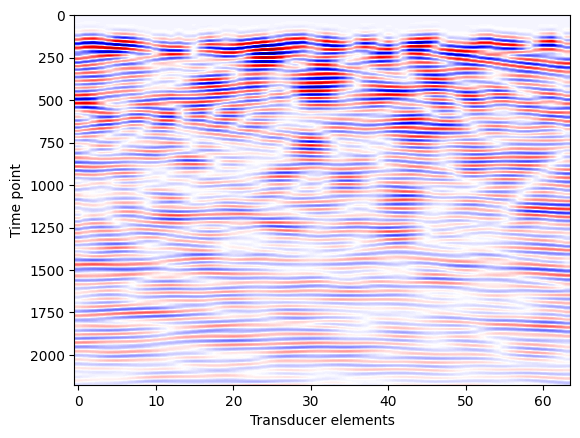

In [12]:
output_data = data-data_skull
plt.imshow(output_data, aspect='auto', cmap='seismic')
plt.xlabel('Transducer elements')
plt.ylabel('Time point')
plt.show()

# Reconstruction

## Single angle

In [13]:
from beamforming_utils import get_receive_beamforming, get_receive_beamforming_medium_specific
# res = get_receive_beamforming(domain, time_axis, element_positions, output_data, signal, carrier_signal, signal_delay)
res = get_receive_beamforming_medium_specific(domain, medium, time_axis, element_positions, output_data, signal, carrier_signal, signal_delay)

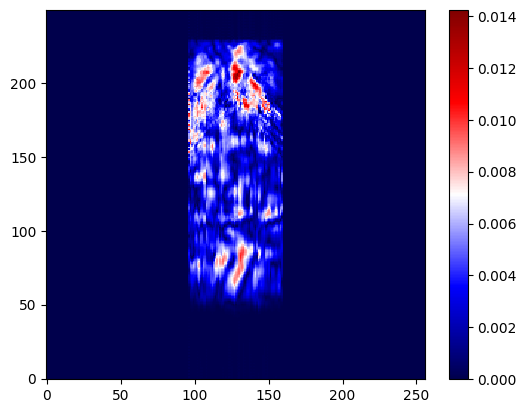

In [14]:
from kwave.utils.filters import gaussian_filter
from kwave.reconstruction.beamform import envelope_detection

def postprocess_result(orig_res):
    result = np.copy(orig_res)
    for i in range(result.shape[0]):
        result[i, :] = gaussian_filter(result[i, :], 1/dx[0], transducer_frequency, 100.0)
    for i in range(result.shape[0]):
        result[i, :] = envelope_detection(result[i, :])
    return np.flipud(result).T

bmode=postprocess_result(res)
plt.imshow(bmode, cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

## Multiple angles

In [16]:
signal_delays = np.linspace(-1, 1, 20)
results = []
for signal_delay in signal_delays:
    print(f"Signal delay: {signal_delay}")
    sources, signal, carrier_signal = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, element_positions, signal_delay=signal_delay)
    _, data = get_data(speed, density, domain, time_axis, sources, element_positions)
    _, data_skull = get_data(speed_skull, density_skull, domain, time_axis, sources, element_positions)
    output_data = data-data_skull
    # res = get_receive_beamforming(domain, time_axis, element_positions, output_data, signal, carrier_signal, signal_delay)
    res = get_receive_beamforming_medium_specific(domain, medium, time_axis, element_positions, output_data, signal, carrier_signal, signal_delay)
    results.append(res)

Signal delay: -1.0
Signal delay: -0.8947368421052632
Signal delay: -0.7894736842105263
Signal delay: -0.6842105263157895
Signal delay: -0.5789473684210527
Signal delay: -0.4736842105263158
Signal delay: -0.368421052631579
Signal delay: -0.26315789473684215
Signal delay: -0.1578947368421053
Signal delay: -0.052631578947368474
Signal delay: 0.05263157894736836
Signal delay: 0.1578947368421053
Signal delay: 0.26315789473684204
Signal delay: 0.36842105263157876
Signal delay: 0.4736842105263157
Signal delay: 0.5789473684210527
Signal delay: 0.6842105263157894
Signal delay: 0.7894736842105261
Signal delay: 0.894736842105263
Signal delay: 1.0


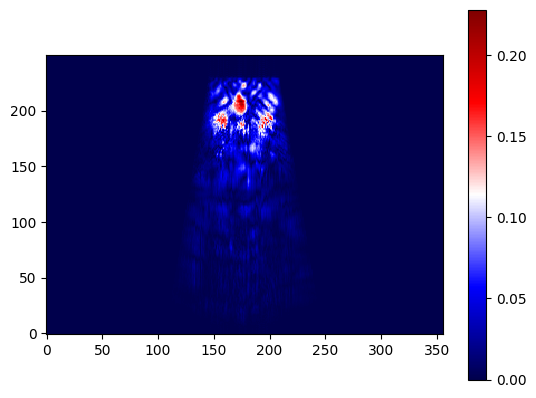

In [17]:
compounded_res = np.sum(results, axis=0)
compounded_bmode=postprocess_result(compounded_res)
# bmodes = [postprocess_result(res) for res in results]
# compounded_bmode = np.sum(bmodes, axis=0)

plt.imshow(compounded_bmode, cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

## Gradient

In [15]:
from jax import value_and_grad
from jwave_utils import get_data_only
from solver_utils import linear_loss, nonlinear_loss

params = speed

# compute first linear gradient
# J = jax.jacrev(get_data_only, argnums=0)(jnp.array(speed), density_homogenous, domain, time_axis, sources, element_positions)
# linear_val_and_grad = value_and_grad(linear_loss, argnums=0)
# linear_loss, linear_gradient = linear_val_and_grad(params, J, output_data)

# compute first nonlinear gradient
nonlinear_val_and_grad = value_and_grad(nonlinear_loss, argnums=0)
nonlinear_loss, nonlinear_gradient = nonlinear_val_and_grad(params, data_skull, density_skull, domain, time_axis, sources, element_positions)
# nonlinear_gradient = nonlinear_gradient.at[:, 90:].set(0) # apply mask
print(f"Nonlinear loss: {nonlinear_loss}")

2024-08-11 20:08:52.055191: W external/xla/xla/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.04GiB (rounded to 1116682240)requested by op 
2024-08-11 20:08:52.055268: W external/xla/xla/tsl/framework/bfc_allocator.cc:494] ***********_________***************************************************************_________________
E0811 20:08:52.055287  121454 pjrt_stream_executor_client.cc:3067] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1116682176 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1116682176 bytes.

In [ ]:
# Viualize
plt.figure(figsize=(8, 6))
plt.imshow(postprocess_result(nonlinear_gradient), cmap='seismic')
plt.title("First gradient")
plt.xlabel('x [gridpoints]')
plt.ylabel('y [gridpoints]')
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.55)
plt.show()